# Tree Ensemble

### In this notebook, I will study the implementation of Decision Tree, Random Forest and XGBoost models using scikit-learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

RANDOM_STATE = 55 # I will pass it to every sklearn call so I ensure reproducibility

# Dataset

The dataset is obtained from: [Heart Failure Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

This dataset contains 11 features that can be used to predict possible heart disease.

#### Attribute Information
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

Let's now load the dataset. As we can see above, the variables:

- Sex
- ChestPainType
- RestingECG
- ExerciseAngina
- ST_Slope

Are *categorical*, so we must one-hot encode them. 

In [2]:
# Load the dataset

In [3]:
df = pd.read_csv("data/Heart_Disease/heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Performing some data engineering before working with the models. I will use Pandas to one-hot encode the categorical features.

## One-hot encoding

In [4]:
cat_variables = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

In [5]:
df = pd.get_dummies(data = df, prefix = cat_variables, columns = cat_variables)          # pd.get_dummies: Convert categorical data into dummy/indicator variables.
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,1,0,0,...,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
3,48,138,214,0,108,1.5,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
4,54,150,195,0,122,0.0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


The target is `HeartDisease`

In [8]:
features = [x for x in df.columns if x not in 'HeartDisease']       # Removing the target variable
features

['Age',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'MaxHR',
 'Oldpeak',
 'Sex_F',
 'Sex_M',
 'ChestPainType_ASY',
 'ChestPainType_ATA',
 'ChestPainType_NAP',
 'ChestPainType_TA',
 'RestingECG_LVH',
 'RestingECG_Normal',
 'RestingECG_ST',
 'ExerciseAngina_N',
 'ExerciseAngina_Y',
 'ST_Slope_Down',
 'ST_Slope_Flat',
 'ST_Slope_Up']

In [7]:
print(len(features))

20


# Splitting the Dataset

In [12]:
X_train, X_val, y_train, y_val = train_test_split(df[features], df['HeartDisease'], train_size = 0.8, random_state=RANDOM_STATE)

In [13]:
print(f'Train samples: {len(X_train)}')
print(f'Validation samples: {len(X_val)}')
print(f'Target proportion: {sum(y_train)/len(y_train):.4f}')

Train samples: 734
Validation samples: 184
Target proportion: 0.5518


I am going to build a Decision Tree using the [Scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

The hyperparameters that I will use are:
- min_samples_split: The minimum number of samples required to split an initernal node.
    - Choosing a higher min_samples_split can reduce the number of splits and may help to reduce overfitting.
- max_depth: The maximum depth of the three.
    - Choosing a lower max_depth can reduce the number splits and may help to reduce overfitting.

In [11]:
min_samples_split_list = [2, 10, 30, 50, 100, 200, 300, 700] ## If the number is an integer, then it is the actual quantity of samples
max_depth_list = [1, 2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit

In [14]:
accuracy_list_train = []
accuracy_list_val = []

for min_samples_split_list in min_samples_split_list:
    # Note: You can fit the model at the same time you define it, because the fit function returns the fitted estimator
    model = DecisionTreeClassifier(min_samples_split = min_samples_split_list, random_state = RANDOM_STATE).fit(X_train, y_train)
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_val = accuracy_score(predictions_val, y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)



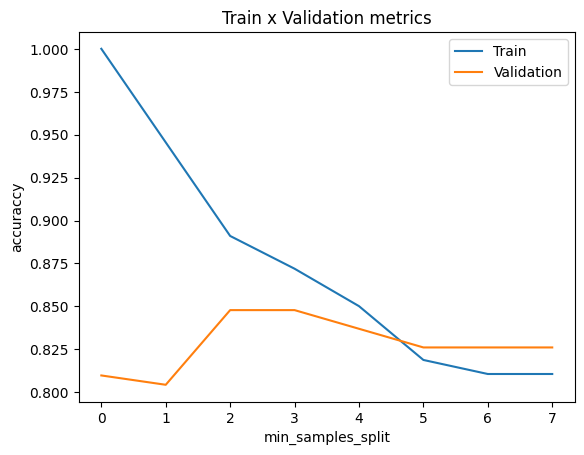

In [20]:
plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuraccy')
#plt.xticks(ticks = range(len(min_samples_split_list)),labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train', 'Validation'])
